# Exercise 1 Solution: SEIRS Model for a Different Country (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-4/solutions/r-colab/exercise_1_seirs_model.ipynb)

Build an SEIRS model (with waning immunity) and simulate it for Brazil using R via the `reticulate` package.

In [ ]:
!pip install epydemix
%load_ext rpy2.ipython

In [3]:
%%R
# Install and load reticulate
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


## Task 1: Create the SEIRS Model

The SEIRS model extends SEIR by adding waning immunity (R -> S transition).

In [4]:
%%R
# Import epydemix
epydemix <- import("epydemix")
EpiModel <- epydemix$EpiModel

# Helper for creating Python tuples
builtins <- import_builtins()

# Create SEIRS model
model <- EpiModel(name = "SEIRS Model", compartments = c("S", "E", "I", "R"))

# S -> E: infection (mediated by I)
params_SE <- builtins$tuple(list("beta", "I"))
model$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")

# E -> I: progression to infectious
model$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")

# I -> R: recovery
model$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")

# R -> S: waning immunity (the key addition for SEIRS)
model$add_transition(source = "R", target = "S", params = "omega", kind = "spontaneous")

# Set parameters
model$add_parameter("beta", 0.03)    # transmission rate
model$add_parameter("sigma", 0.2)    # 1/5 day latent period
model$add_parameter("gamma", 0.1)    # 1/10 day infectious period
model$add_parameter("omega", 0.01)   # 1/100 day immunity duration

model

EpiModel(name='SEIRS Model')
Compartments: 4
  S, E, I, R
Transitions: 4
  Transitions between compartments:
    S -> E, params: ['beta', 'I'] (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
    R -> S, params: omega (kind: spontaneous)
Parameters: 4
  Model parameters:
    beta: 0.03
    sigma: 0.2
    gamma: 0.1
    omega: 0.01
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



## Task 2: Load Population Data

Let's use Brazil as our example country.

In [5]:
%%R
# Load population module
load_epydemix_population <- epydemix$population$load_epydemix_population

# Load Brazil population data
population <- load_epydemix_population("Brazil")
model$set_population(population)

population

Population(name='Brazil')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 13218241 individuals
  - 5-19: 43651312 individuals
  - 20-49: 96265908 individuals
  - 50-64: 35514607 individuals
  - 65+: 22924390 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



<Axes: title={'center': 'Contact Matrix - community'}, xlabel='Age group (contacted)', ylabel='Age group (contacting)'>


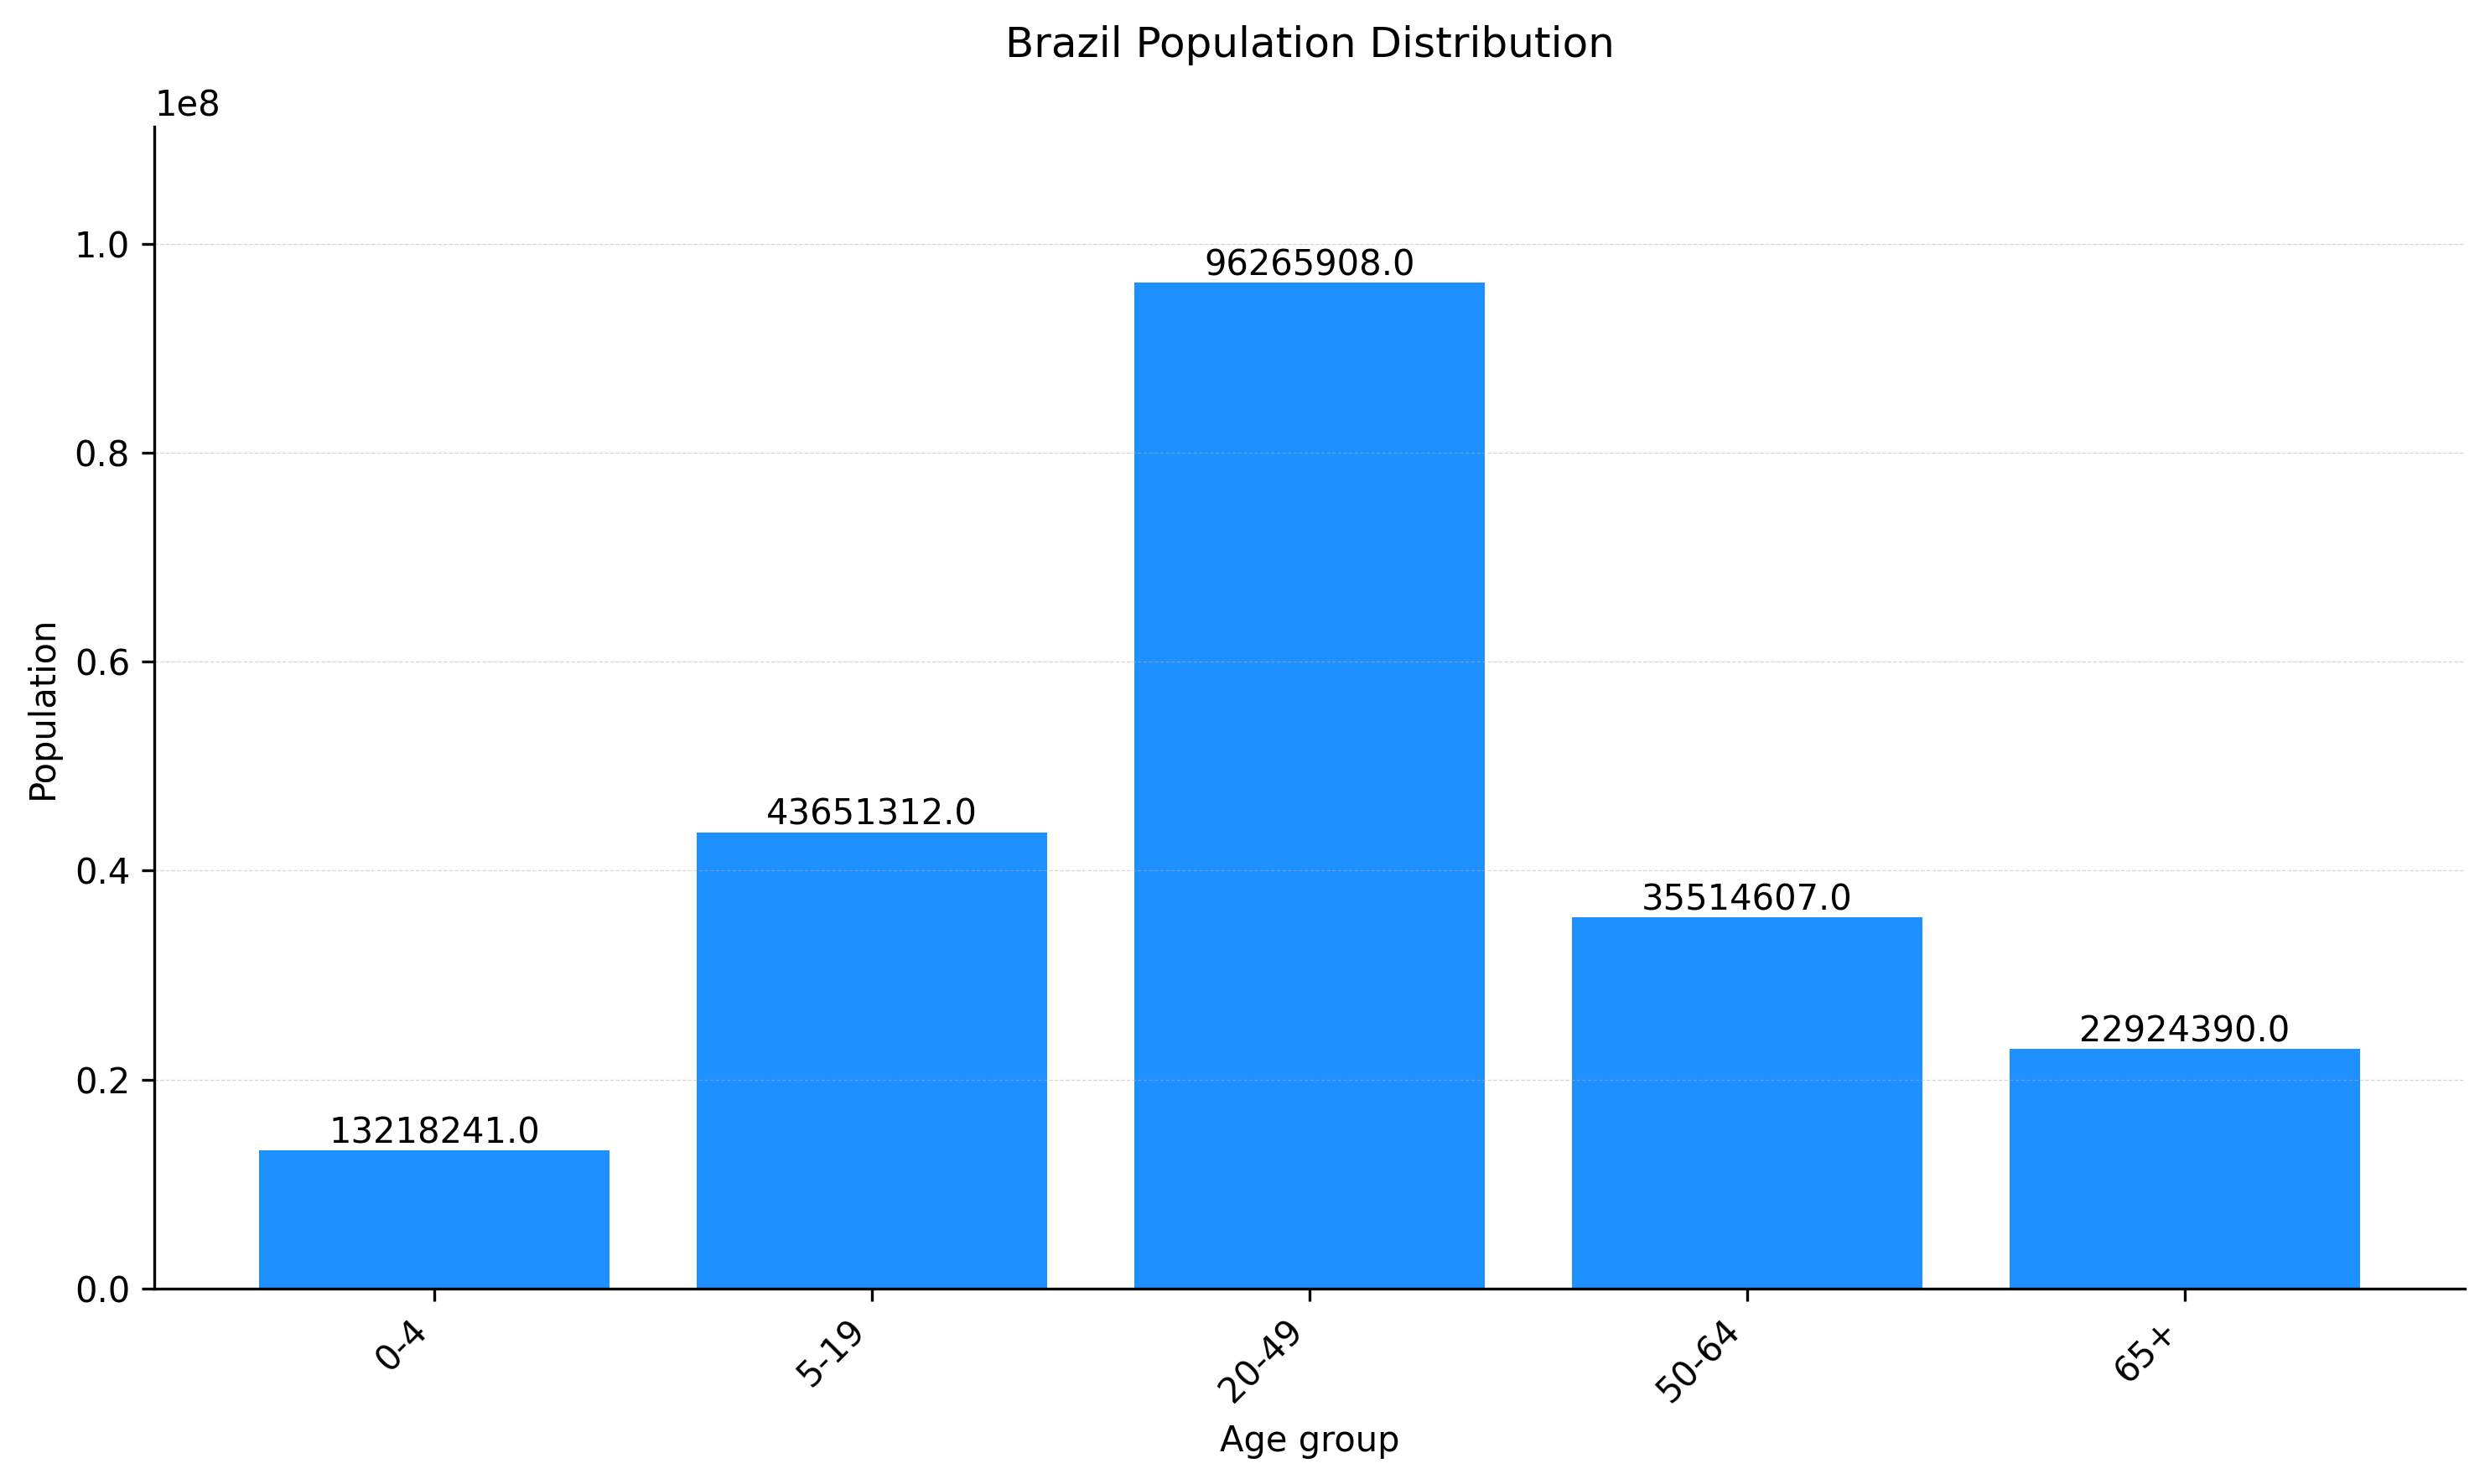

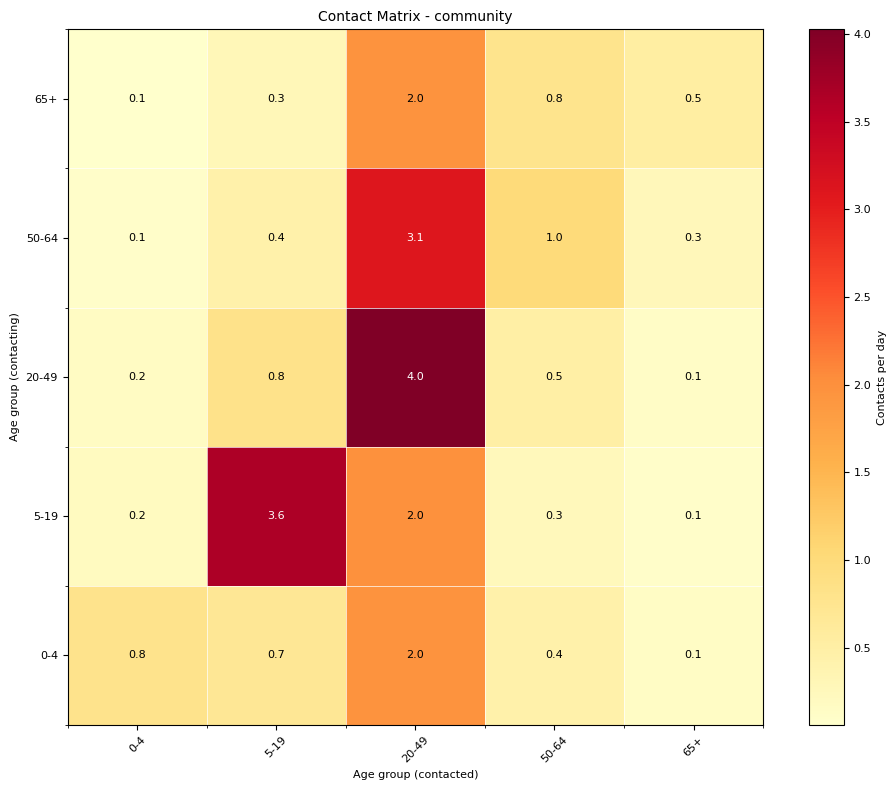

In [6]:
%%R
# Import visualization functions
viz <- import("epydemix.visualization")
plot_population <- viz$plot_population
plot_contact_matrix <- viz$plot_contact_matrix

# Plot population distribution
plot_population(population, title = "Brazil Population Distribution")
plot_contact_matrix(population, "community", show_values = TRUE)

## Task 3: Run Simulations and Visualize

In [7]:
%%R
# Compute percentage for seeding ~10 infected individuals
Nk_r <- py_to_r(population$Nk)
percentage_in_agents <- 10 / sum(Nk_r)

# Run 50 stochastic simulations over 1 year
results <- model$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-12-31",
  Nsim = 50L,
  percentage_in_agents = percentage_in_agents
)

<Axes: title={'center': 'SEIRS Model - Brazil (1 Year)'}>


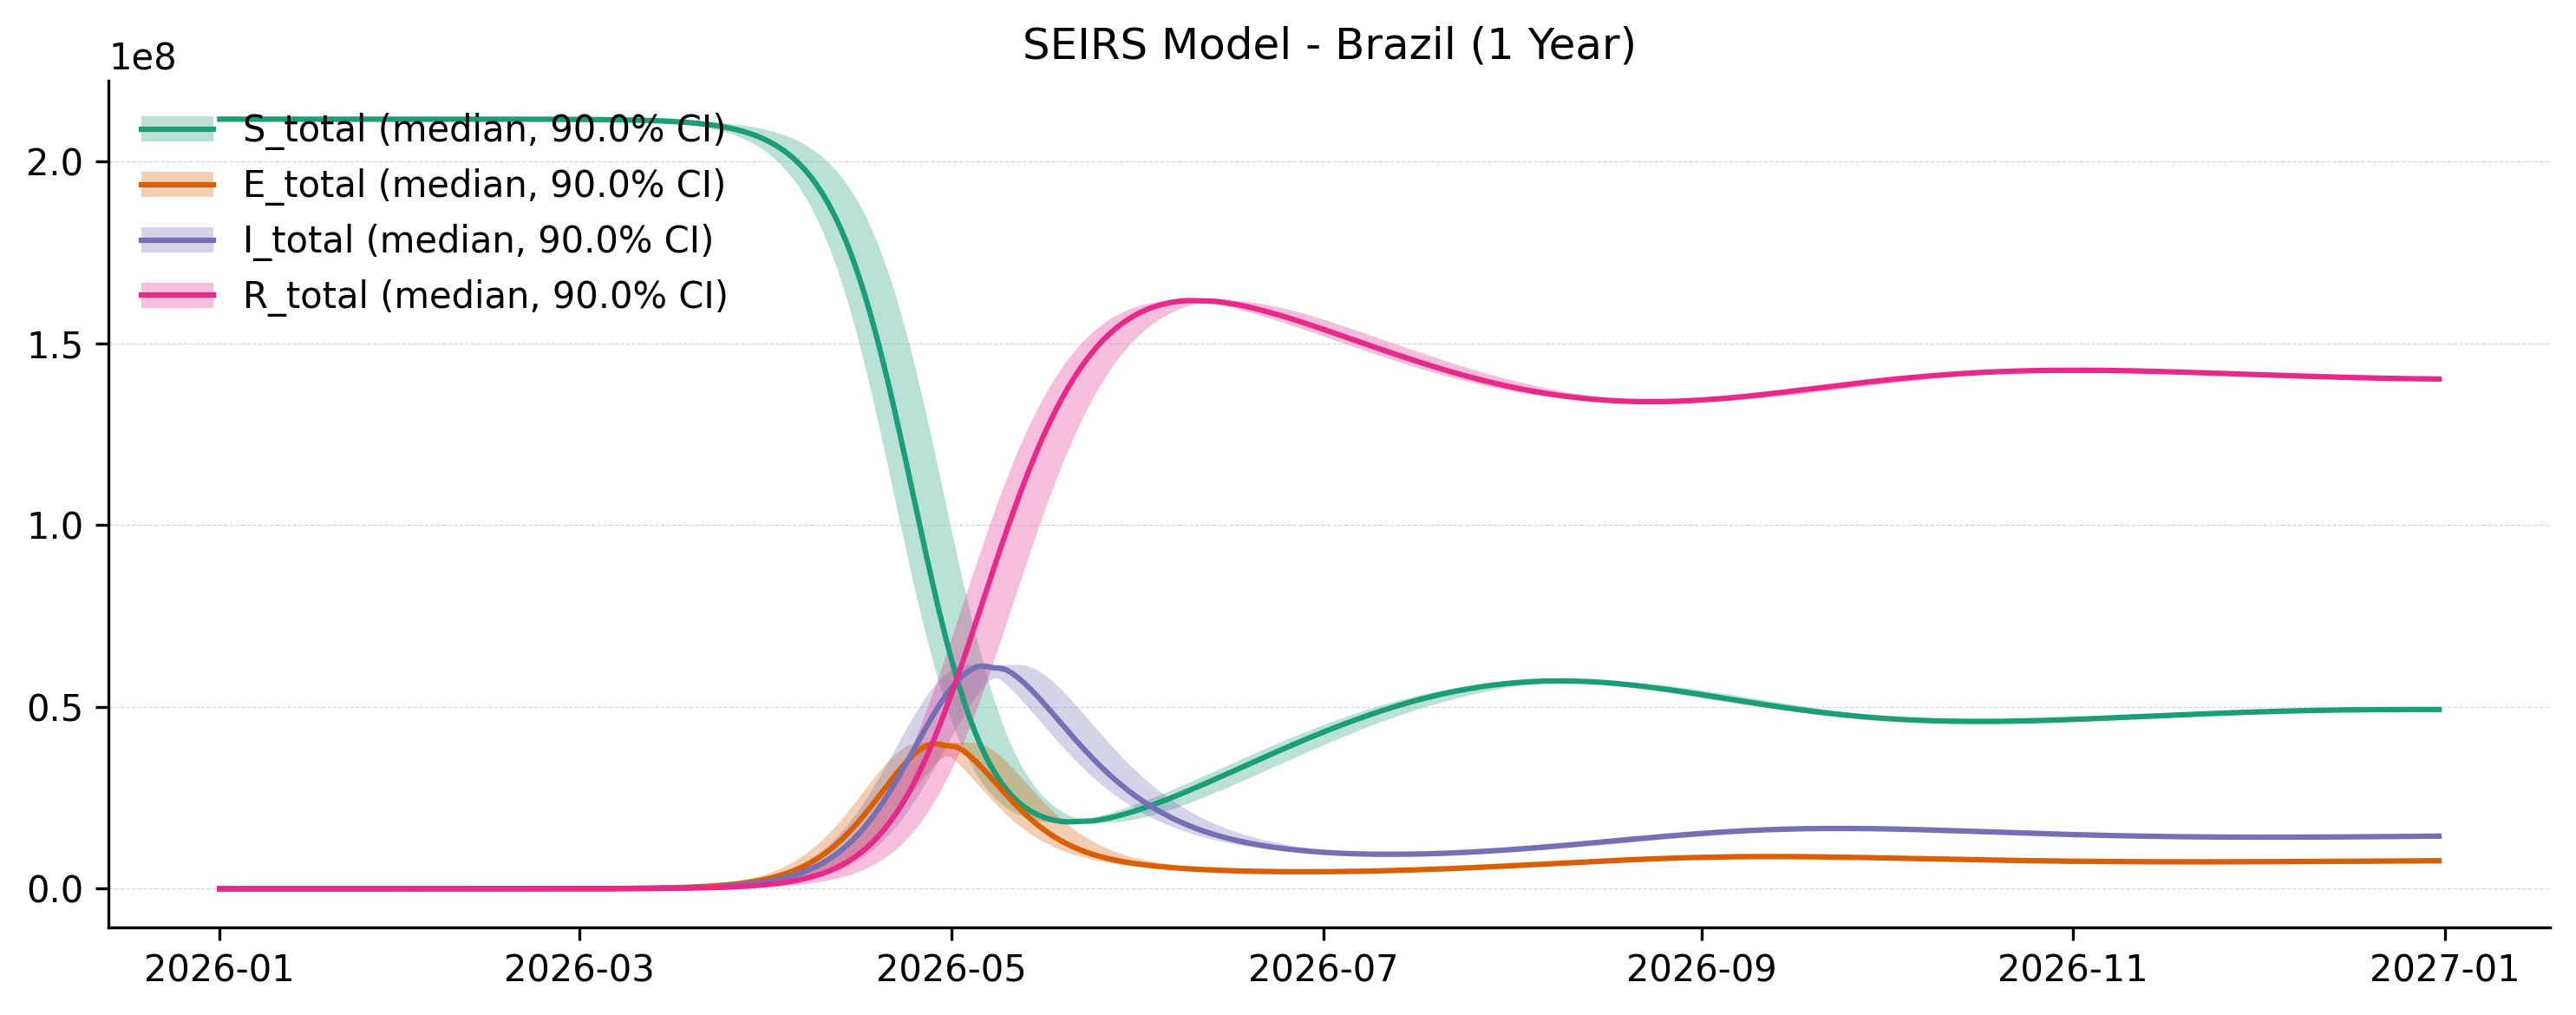

In [8]:
%%R
# Import plotting functions
plot_quantiles <- viz$plot_quantiles

# Get quantiles across simulations
df_quantiles <- results$get_quantiles_compartments()

# Plot all compartments
plot_quantiles(
  df_quantiles,
  columns = c("S_total", "E_total", "I_total", "R_total"),
  title = "SEIRS Model - Brazil (1 Year)"
)

<Axes: title={'center': 'Infections by Age Group'}>


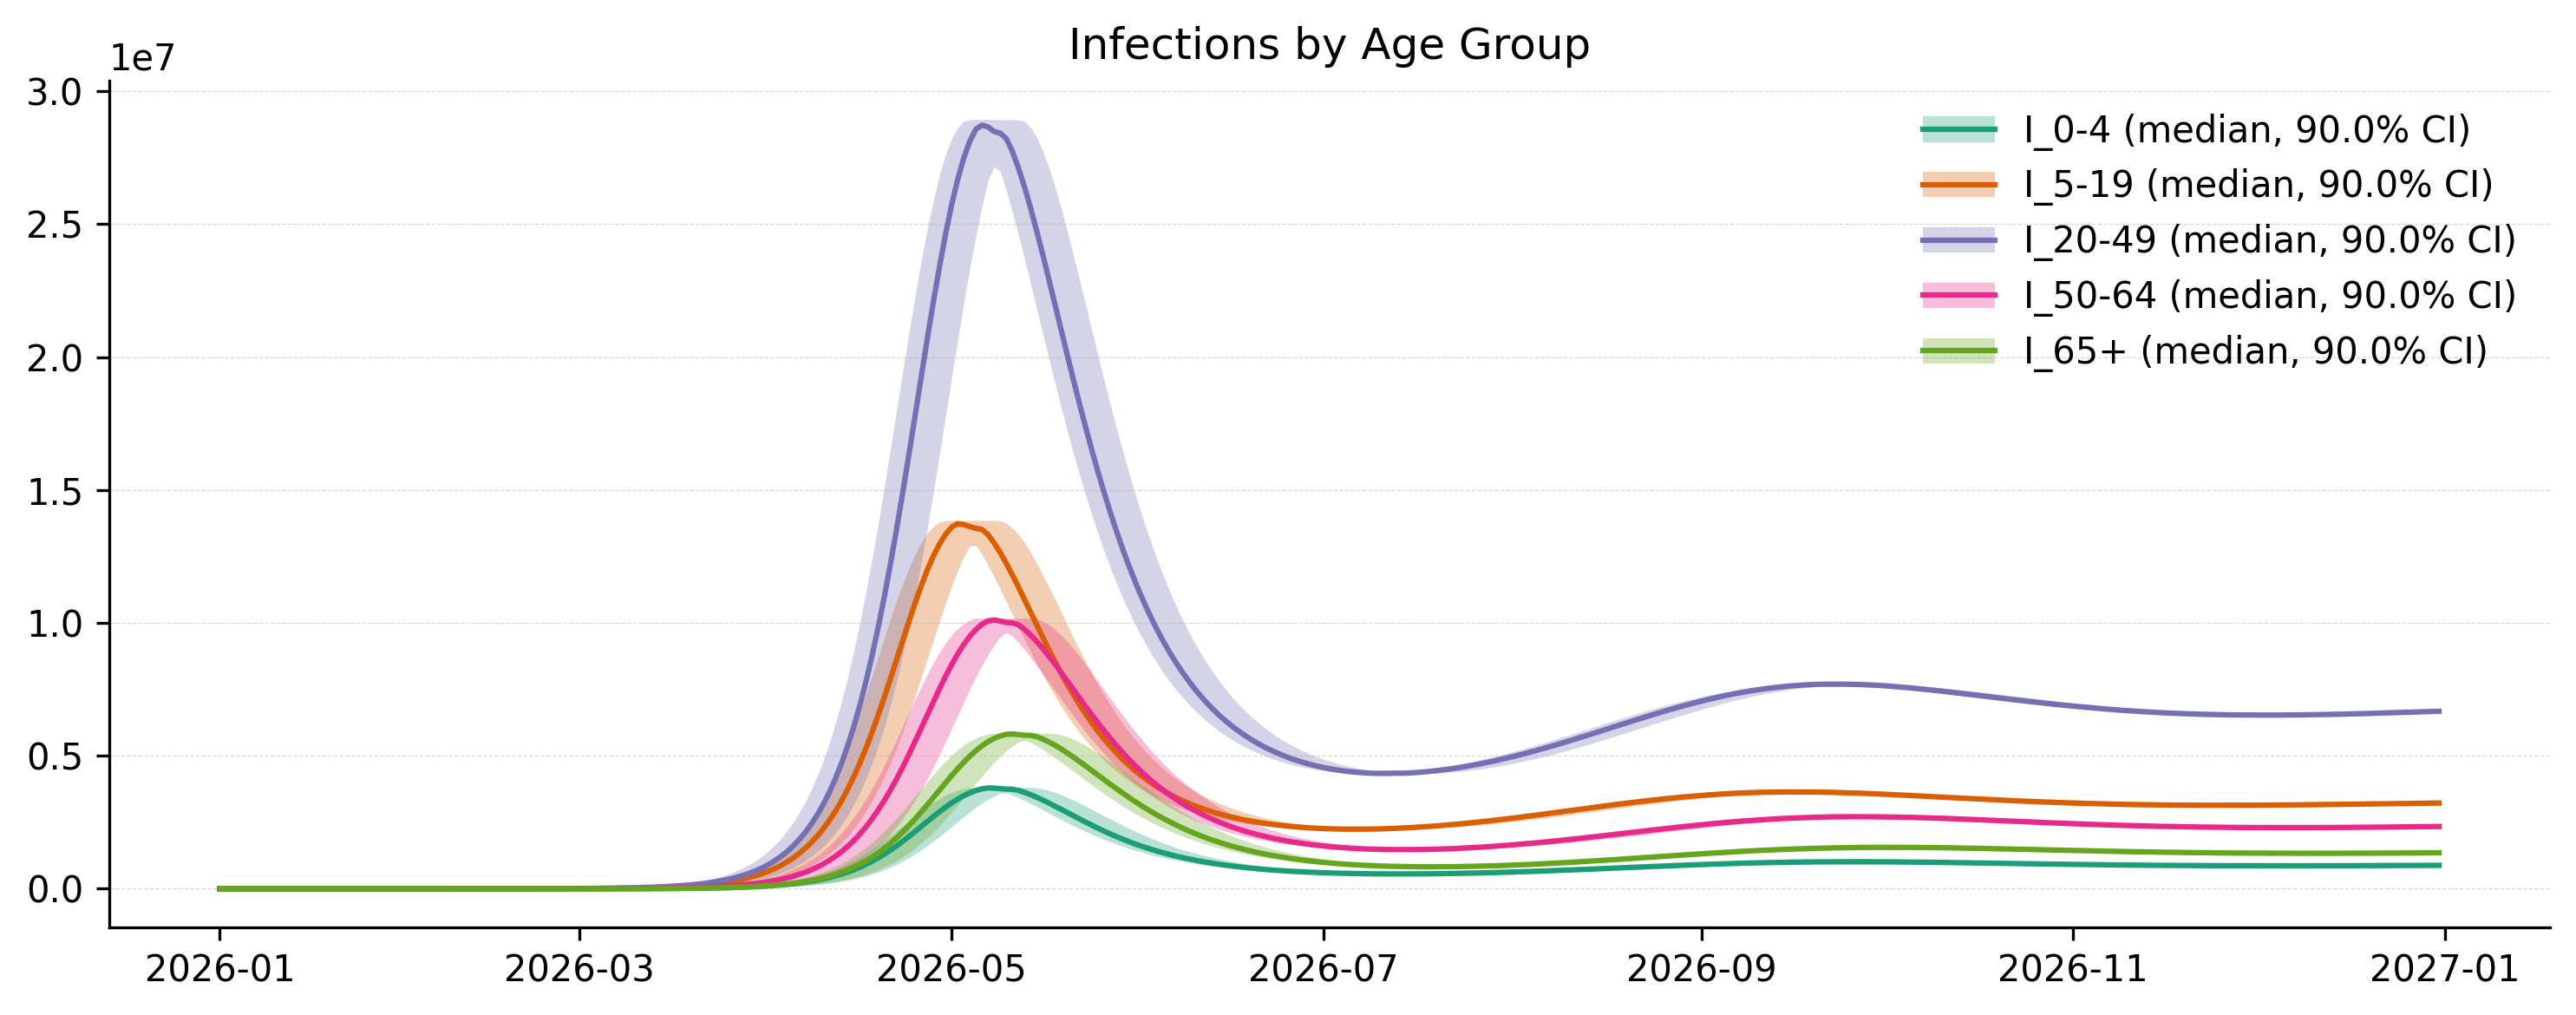

In [9]:
%%R
# Infections by age group
plot_quantiles(
  df_quantiles,
  columns = c("I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"),
  title = "Infections by Age Group",
  legend_loc = "upper right"
)

## Task 4: Compare SEIRS vs SEIR

Let's compare the dynamics with and without waning immunity.

In [10]:
%%R
# Create standard SEIR model (no waning)
model_seir <- EpiModel(name = "SEIR Model", compartments = c("S", "E", "I", "R"))

params_SE <- builtins$tuple(list("beta", "I"))
model_seir$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")
model_seir$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")
model_seir$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")
# No R -> S transition!

model_seir$add_parameter("beta", 0.03)
model_seir$add_parameter("sigma", 0.2)
model_seir$add_parameter("gamma", 0.1)
model_seir$set_population(population)

# Run simulations
results_seir <- model_seir$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-12-31",
  Nsim = 50L,
  percentage_in_agents = percentage_in_agents
)

<Axes: title={'center': 'Infected Over Time'}>


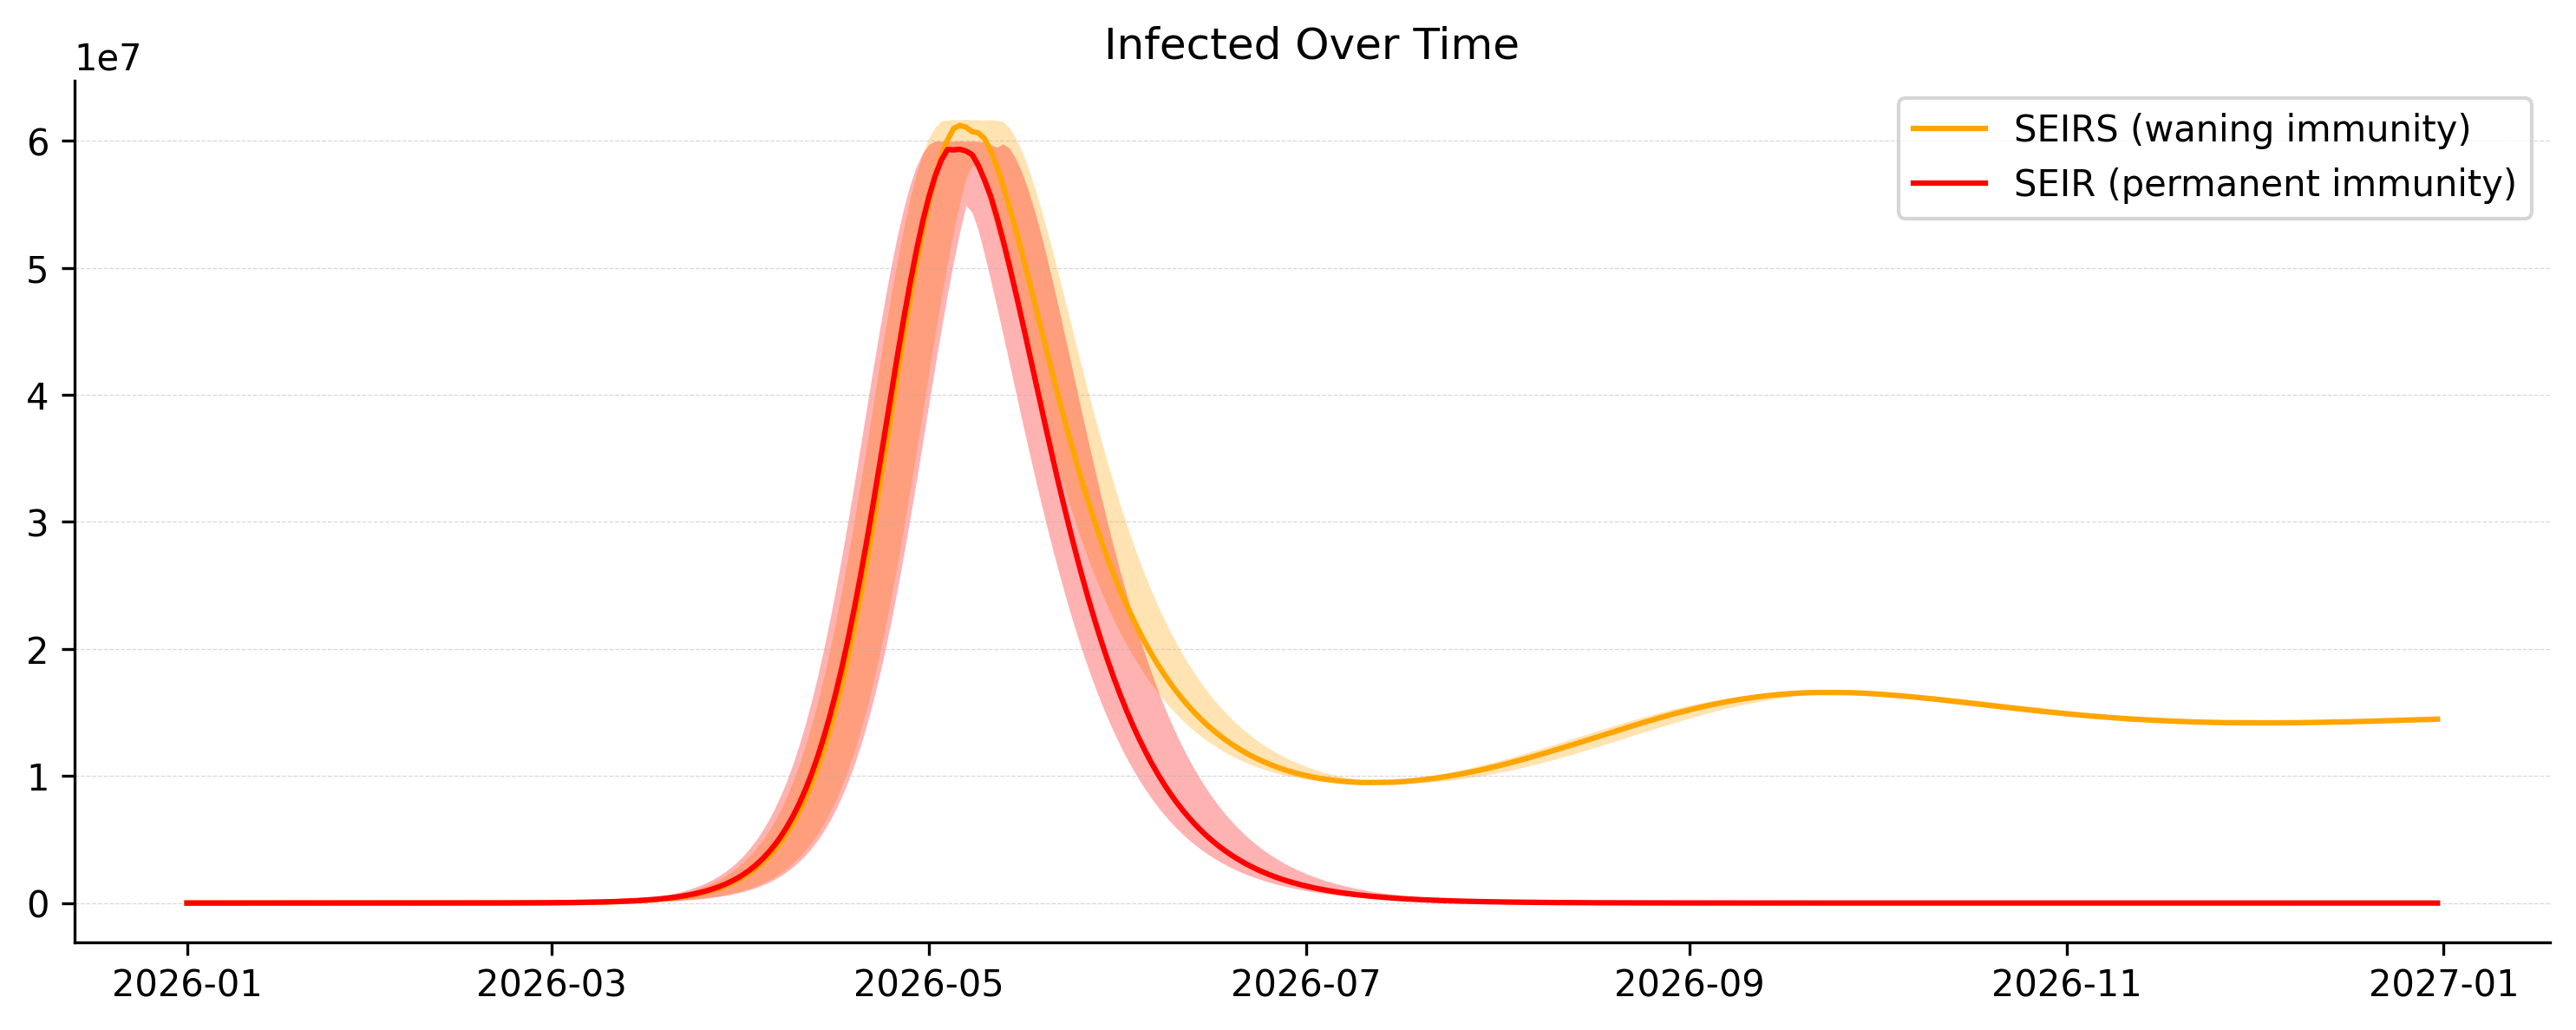

In [13]:
%%R
df_seir <- results_seir$get_quantiles_compartments()

# Infected comparison
ax <- plot_quantiles(
  df_quantiles, columns = c("I_total"),
  colors = "orange", labels = list("SEIRS (waning immunity)")
)
ax <- plot_quantiles(
  df_seir, columns = c("I_total"),
  colors = "red", labels = list("SEIR (permanent immunity)"),
  ax = ax
)
ax$set_title("Infected Over Time")
ax$legend()
ax

<Axes: title={'center': 'Susceptible Over Time'}>


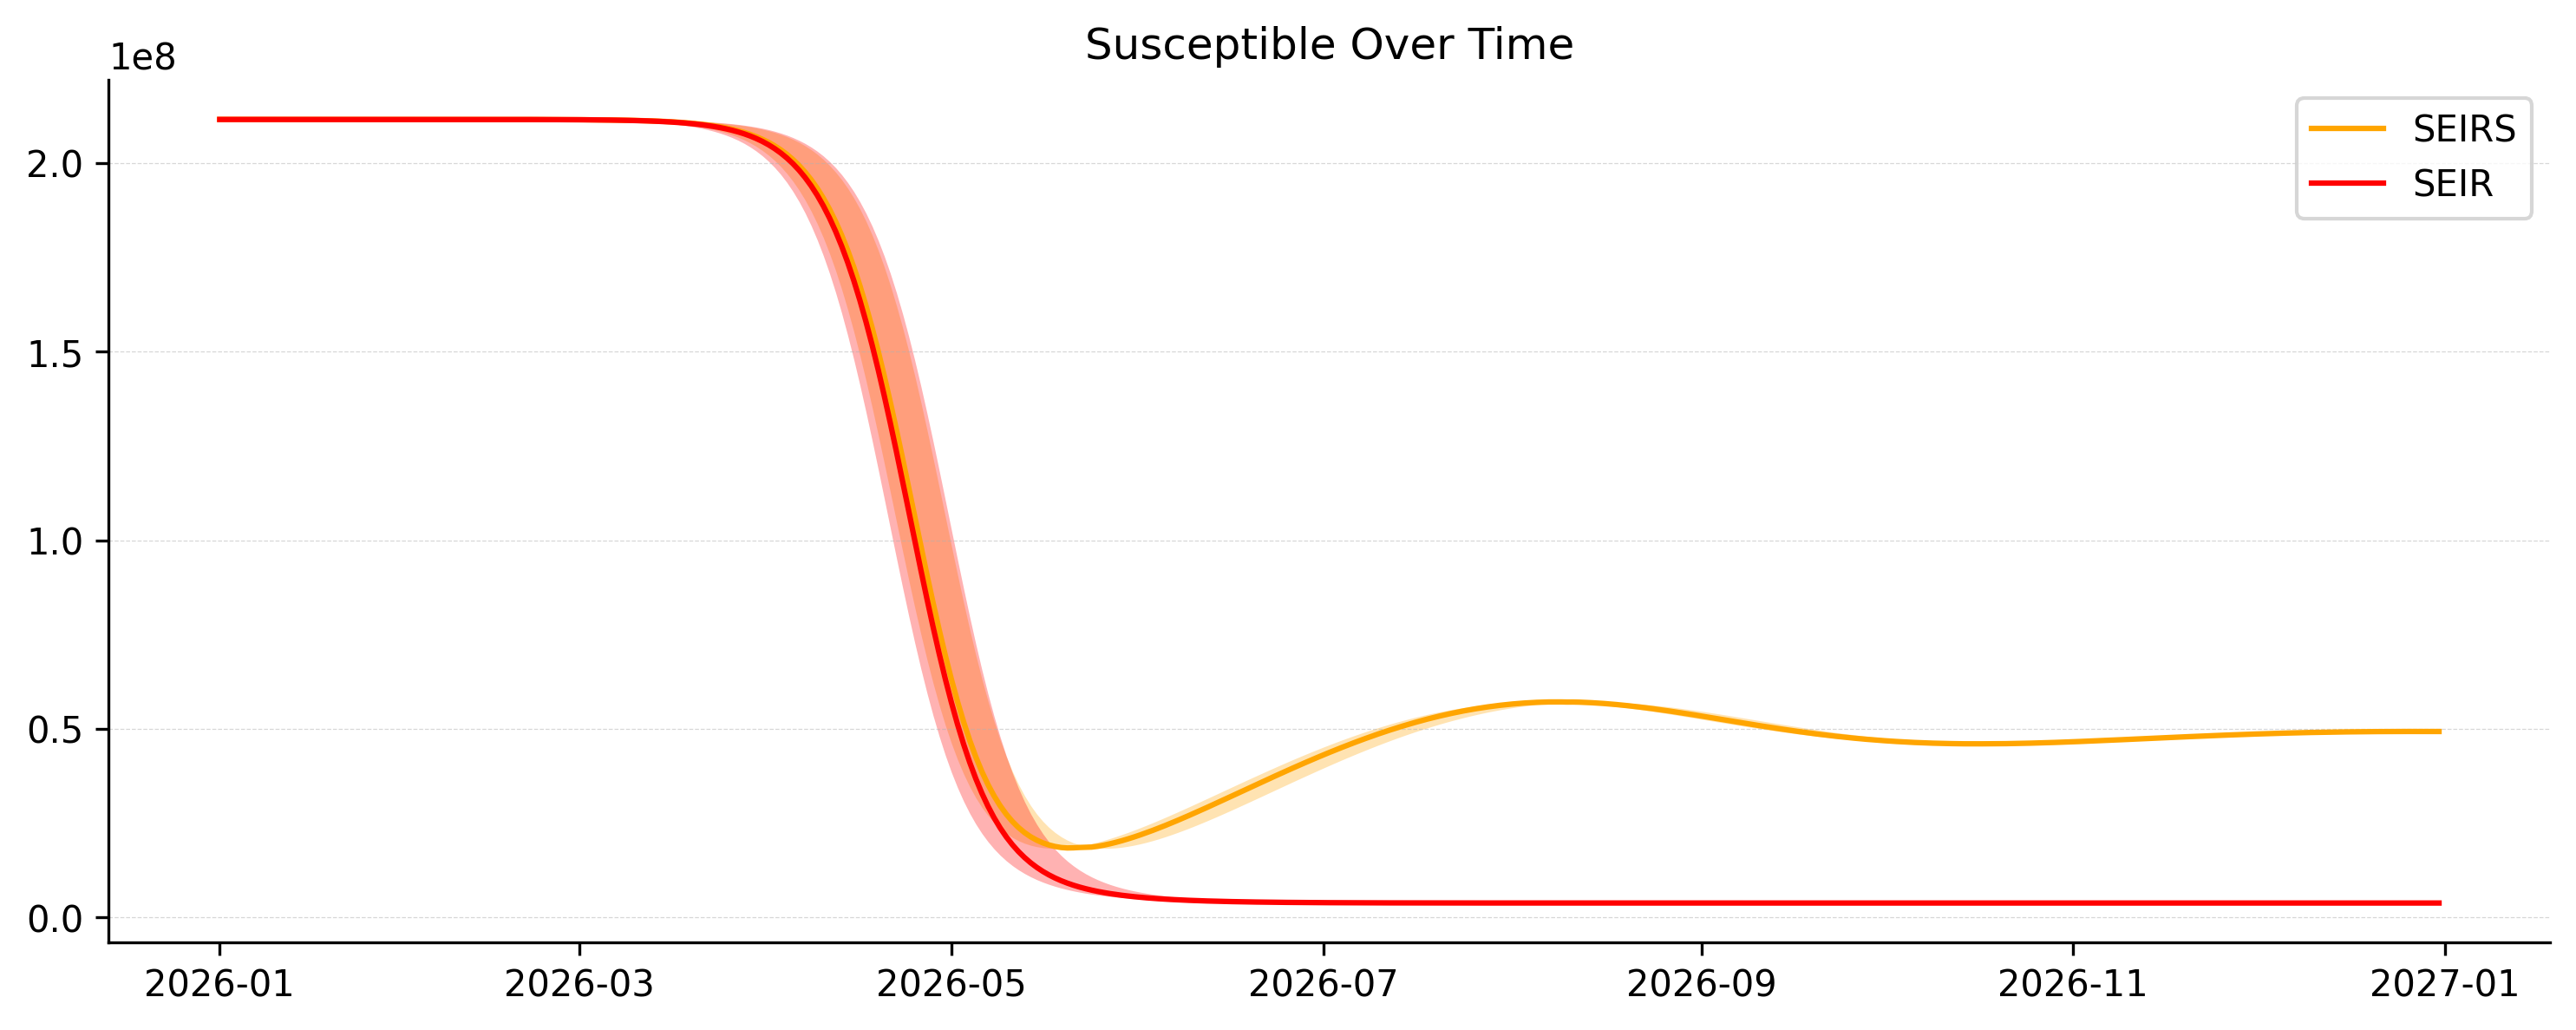

In [14]:
%%R
# Susceptible comparison
ax <- plot_quantiles(
  df_quantiles, columns = c("S_total"),
  colors = "orange", labels = list("SEIRS")
)
ax <- plot_quantiles(
  df_seir, columns = c("S_total"),
  colors = "red", labels = list("SEIR"),
  ax = ax
)
ax$set_title("Susceptible Over Time")
ax$legend()
ax

## Discussion

**How does waning immunity affect the long-term dynamics?**

1. **SEIR (permanent immunity):** The epidemic burns through the population once and then dies out when herd immunity is reached. Susceptibles decrease monotonically.

2. **SEIRS (waning immunity):**
   - The susceptible pool is continuously replenished as recovered individuals lose immunity
   - This can lead to **recurrent epidemic waves** or **endemic equilibrium**
   - With omega=0.01 (100-day immunity), we see the infection persisting longer

**Key insight:** Waning immunity is crucial for modeling diseases where reinfection is possible (e.g., influenza, common cold coronaviruses, RSV). The rate of waning (omega) determines whether the disease becomes endemic or causes periodic epidemics.